# **Connect to my drive**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir("./drive/My Drive/")
print(os.getcwd())

/content/drive/My Drive


# **Select Tensorflow's version**

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Install libraries

In [ ]:
!pip install pydicom
!pip install SimpleITK
!pip install medpy

     |████████████████████████████████| 35.5MB 89kB/s 
     |████████████████████████████████| 42.5MB 72kB/s 
     |████████████████████████████████| 153kB 4.6MB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753437 sha256=08a8c60d308b785af70dea463aefb46fa5dbe84ccb16ed7296048d508ecf7629
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


#Import libraries

In [ ]:
#library for read file dicom,nifti,...
import pydicom as dcm
import natsort
import glob, os
import pandas as pd
import numpy as np
from medpy.io import load
#library for plot image
import matplotlib.pyplot as plt
#library for preprocessing
from skimage.transform import resize
from scipy import ndimage
from scipy.ndimage import binary_fill_holes
import SimpleITK as sitk
from skimage import img_as_ubyte
from sklearn.model_selection import train_test_split
import skimage
import warnings
warnings.filterwarnings("ignore")
# library for process image
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage import io
import SimpleITK as sitk
#some system library
import time
import datetime
#library for create keras model
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D,UpSampling2D,BatchNormalization, MaxPooling2D, Conv2DTranspose, Activation,Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from keras.metrics import accuracy,MeanIoU
import tensorflow as tf

#Create some functions to load data, preprocessing and plot image

## Preprocessing and plot image functions

In [ ]:
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
def crop_liver(input_img,mask):
  col_maxes = np.max(mask, axis=0) # a row
  row_maxes = np.max(mask, axis=0)# a column
  nonzero_colmaxes = np.nonzero(col_maxes)[1]
  nonzero_rowmaxes = np.nonzero(row_maxes)[0]
  x1, x2 = min(nonzero_colmaxes), max(nonzero_colmaxes)
  y1, y2 = min(nonzero_rowmaxes), max(nonzero_rowmaxes)
  width = x2-x1
  height= y2-y1
  MIN_WIDTH = 180
  MIN_HEIGHT = 160

  x_pad = (MIN_WIDTH - width) / 2 if width < MIN_WIDTH else 0
  y_pad = (MIN_HEIGHT - height)/2 if height < MIN_HEIGHT else 0

  x1 = max(0, x1-x_pad)
  x2 = min(320, x2+x_pad)
  y1 = max(0, y1-y_pad)
  y2 = min(230, y2+y_pad)
  return x1,x2,y1,y2
def crop_single_liver(image,label,min_width,min_height):
  col_maxes = np.max(label, axis = 1)
  row_maxes = np.max(label,axis = 0)
  nonzero_colmaxes = np.nonzero(col_maxes)[0]
  nonzero_rowmaxes = np.nonzero(row_maxes)[0]
  # print(nonzero_colmaxes)
  x1,x2 = min(nonzero_colmaxes), max(nonzero_colmaxes)
  y1,y2 = min(nonzero_rowmaxes),max(nonzero_rowmaxes)
  width =x2-x1
  height =y2-y1

  MIN_WIDTH = min_width
  MIN_HEIGHT = min_height
  x_pad = (MIN_WIDTH - width) / 2 if width < MIN_WIDTH else 0
  y_pad = (MIN_HEIGHT  - height) / 2 if height < MIN_HEIGHT else 0

  x1= max(0,x1-x_pad)
  x2= min(image.shape[1],x2+x_pad)  
  y1 = max(0,y1-y_pad)
  y2 = min(image.shape[0], y2+y_pad)
  return x1,x2,y1,y2
def resize_image(data,size):
  data = resize(data,(data.shape[0],size[0],size[1]),preserve_range=False)
  return data
def padding_and_resize(range,size,img):
  img = padding_image(range,img)
  img = resize_image(img,size)
  return img

  def padding_image(range,img):
  pad_img = np.ones([img.shape[0],img.shape[1]+2*range, img.shape[2]+2*range])*img[0,0,0]
  pad_img = pad_img[:,:,:,np.newaxis]
  pad_img[:,range:-range,range:-range] = img
  img = pad_img
  return img
def normalization_mask(mask):
  mask[mask > 0.5] = 1
  mask[mask <=0.5] = 0
  nor_mask = img_as_ubyte(mask)
  for i in range(nor_mask.shape[0]):
    nor_mask[i,:,:,:] = binary_fill_holes(nor_mask[i,:,:,:]).astype(np.uint8)
  print(np.count_nonzero(nor_mask))
  return nor_mask
def del_slices(data,mask):
  i = 0
  t = 0
  while t == 0:
    t = np.count_nonzero(mask[i,:,:,0])
    i += 1
  rs = data[i:i+1,:,:,:]
  rs_mask = mask[i:i+1,:,:,:]
  i += 1
  while i < data.shape[0]:
    t = np.count_nonzero(mask[i,:,:,0])
    if t == 0:
      i += 1
    else:
      j = i
      while t != 0:
        j+=1
        t = np.count_nonzero(mask[j,:,:,0])
      rs_i = data[i:j,:,:,:]
      rs_mask_i = mask[i:j,:,:,:]
      rs = np.concatenate((rs,rs_i),axis=0)
      rs_mask =np.concatenate((rs_mask,rs_mask_i),axis=0)
      i += (j-i)
  return rs,rs_mask
def crop_image(img,label):
  x1,x2,y1,y2 = map(int,crop_liver(img,label))
  img = img[:,y1:y2+1,x1:x2+1,:]
  label = label[:,y1:y2+1,x1:x2+1,:]
  img = padding_and_resize(33,(256,256),img)
  label = padding_and_resize(33,(256,256),label)
  return img,label
def crop_image_iterates(img, label, size ):
  temp_img = img
  temp_label = label
  # create result
  new_img = np.zeros((0,256,256,1))
  new_label = np.zeros((0,256,256,1))
  for i in range(temp_img.shape[0]):
    width = 256
    height = 256
    while width >= 170 and height >=170:
      min_width = width - size[0]
      min_height = height - size[1]
      if min_width < 100 or height < 100:
        min_width = 100
        min_height = 100
      #crop image
      x1,x2,y1,y2 = map(int,crop_single_liver(temp_img[i,:,:,0],temp_label[i,:,:,0],min_width,min_height))
      image_i = temp_img[i,x1:x2+1,y1:y2+1,0]
      label_i = temp_label[i,x1:x2+1,y1:y2+1,0]
      image_i = image_i[np.newaxis,:,:,np.newaxis]
      label_i = label_i[np.newaxis,:,:,np.newaxis]
      # image_i = padding_image(33,image_i)
      # label_i = padding_image(33,label_i)
      image_i = resize(image_i,(1,256,256,1),preserve_range=False)
      label_i = resize(label_i,(1,256,256,1),preserve_range=False)
      
      new_img = np.concatenate((new_img,image_i),axis=0)
      new_label = np.concatenate((new_label,label_i), axis=0)

      width = width - size[0]
      height = height - size[1]
  a = np.count_nonzero(new_label)
  print(a)
  return new_img,new_label
def add_noise(image,label,noise):
  temp_img = image/512.0
  image = skimage.util.random_noise(temp_img,mode=noise,var = 0.05**2)
  return image, label
def noise(image,label,mode):
  noise_image,noise_label = image,label
  for i in range(noise_image.shape[0]):
    noise_image[i,:,:,:], noise_label[i,:,:,:] = add_noise(image[i,:,:,:],label[i,:,:,:],mode[0])
  for i in range(1,len(mode)):
    noise_image_i,noise_label_i = image,label
    for j in range(image.shape[0]):
      noise_image_i[j,:,:,:], noise_label_i[j,:,:,:] = add_noise(image[j,:,:,:],label[j,:,:],mode[i])
    noise_image = np.concatenate((noise_image,noise_image_i),axis=0)
    noise_label = np.concatenate((noise_label,noise_label_i),axis=0)
  return noise_image,noise_label

def padding_resize_image_label(image,label):
  print("1. Padding 33 pixel and resize")
  image = padding_and_resize(33,(256,256),image)
  label = padding_and_resize(33,(256,256),label)
  a = np.count_nonzero(label)
  print(a)
  # print("3. Normalization mask")
  # label = normalization_mask(label)
  return image,label

## Load data function

In [ ]:
def load_data():

    def read_nifti_files(filename):
          image = sitk.ReadImage(filename)  # Use ITK to read the image
          image = sitk.GetArrayFromImage(image)  # Turn ITK image object into a numpy array
          return image

    def read_dicom_files(directory,filespattern):
      print(directory)
      if not os.path.exists(directory) or not os.path.isdir(directory):
        raise ValueError("Given directory does not exist or is a file : "+str(directory))
      lstFilesDCM = natsort.natsorted(glob.glob(os.path.join(directory, filespattern)))
      # Get ref file
      RefDs = dcm.read_file(lstFilesDCM[0])
      # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
      ConstPixelDims = (len(lstFilesDCM),int(RefDs.Rows), int(RefDs.Columns))
      # The array is sized based on 'ConstPixelDims'
      ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
      for filenameDCM in lstFilesDCM:
          # read the file
          ds = dcm.read_file(filenameDCM)
          # store the raw image data
          ArrayDicom[lstFilesDCM.index(filenameDCM),:, : ] = ds.pixel_array
      return ArrayDicom

    def read_mha_files(directory,name_image):
      if not os.path.exists(directory) or not os.path.isdir(directory):
        raise ValueError("Given directory does not exist or is a file : "+str(directory))
      image_data,image_header = load(os.path.join(directory,name_image))
      return image_data

  
    def test_load(nameImage, arg):
      basedir = './new_data_preprocessing'
      dir2='./data_preprocessing'
      train = read_nifti_files(os.path.join(basedir, str(arg[0])+str(nameImage)))
      # train = train/255
      train = train.astype('float32')
      y_train = read_nifti_files(os.path.join(dir2, str(arg[0])+'_targetMask.nii'))
      train = ndimage.rotate(train,180,axes=(1,2),reshape=True)
      y_train = ndimage.rotate(y_train,180,axes=(1,2),reshape=True)
      for i in range(1,len(arg)):
        
          train_1 = read_nifti_files(os.path.join(basedir, str(arg[i])+str(nameImage)))
          # train_1 = train_1/255
          train_1 = train_1.astype('float32')
          y_train_1 = read_nifti_files(os.path.join(dir2, str(arg[i])+'_targetMask.nii'))
          train_1 = ndimage.rotate(train_1,180,axes=(1,2),reshape=True)
          y_train_1 = ndimage.rotate(y_train_1,180,axes=(1,2),reshape=True)
          train = np.concatenate((train, train_1), axis=0)
          y_train = np.concatenate((y_train, y_train_1), axis=0)
      
      return train, y_train
    def load_train():
      train_i = np.asarray([1,3,4,6,9,15,16,10,11,12,13,14,17,25,26,28,29,30,31])
      # train_i = np.asarray([1,3,6,16,10,11,12,13,14,17,25,26,28,29,30,31])
      train_x, train_y = test_load(nameImage='_inputImage_1.nii', arg=train_i)
      train_x = train_x[:,:,:, np.newaxis]
      train_y = train_y[:,:,:, np.newaxis]

      print("Load train completed!")
      return train_x,train_y

    def load_validate():
        val_i = np.asarray([4,9,15])
            
        val_x, val_y = test_load(nameImage='_inputImage_1.nii', arg=val_i)
        val_x = val_x[:,:,:, np.newaxis]
        val_y = val_y[:,:,:, np.newaxis]

        
        print("Load validate data completed!")

        return val_x,val_y

    def load_test():
        test_i = np.asarray([2,7,27])
            
        test_x, test_y = test_load(nameImage='_inputImage_1.nii', arg=test_i)
        test_x = test_x[:,:,:, np.newaxis]
        test_y = test_y[:,:,:, np.newaxis]
      

        print("Load test completed!")

        return test_x,test_y

    train_x, train_y = load_train()
    test_x, test_y = load_test()
    val_x,val_y = load_validate()
    return train_x,train_y,test_x,test_y,val_x,val_y

##Using function to load data, preprocessing and plot image



In [ ]:
train_x,train_y,test_x,test_y,val_x,val_y = load_data()

Load train completed!
Load test completed!
Load validate data completed!


In [ ]:
temp_train_y = train_y
temp_test_y = test_y
temp_val_y = val_y

In [ ]:
print(train_x.shape,train_y.shape,temp_train_y.shape)

(1064, 230, 320, 1) (1064, 230, 320, 1) (1064, 230, 320, 1)


In [ ]:
print('-'*30)
print('TRAIN!!!')
print('-'*30)
print('PREPROCESSING')
print('-'*30)
input_data,mask_data = del_slices(train_x,temp_train_y)
input_data, mask_data = padding_resize_image_label(input_data,mask_data)
print(input_data.shape,mask_data.shape)


------------------------------
TRAIN!!!
------------------------------
PREPROCESSING
------------------------------
1. Padding 33 pixel and resize
2941472
(830, 256, 256, 1) (830, 256, 256, 1)


In [ ]:
# select_noise = ["gaussian","speckle"]
select_noise = ["gaussian"]
print('-'*30)
print('Add noise!')
print('-'*30)


# flip_input = ndimage.rotate(input_data,90,axes=(1,2),reshape=True)
# flip_mask = ndimage.rotate(mask_data,90,axes=(1,2),reshape=True)
# print('-'*30)
print('TEST!!!')
print('-'*30)
test_p,test_y_p = padding_resize_image_label(test_x,test_y)
test_p = test_p.astype(np.float32)
test_y_p = normalization_mask(test_y_p)

# input_data = np.concatenate((input_data,input_noise),axis=0)
# mask_data = np.concatenate((mask_data,mask_noise),axis=0)

------------------------------
Add noise!
------------------------------
TEST!!!
------------------------------
1. Padding 33 pixel and resize
421646
389888


In [ ]:
input_data.shape

(830, 256, 256, 1)

In [ ]:
from sklearn.model_selection import train_test_split
train_p,val_p,train_y_p,val_y_p = train_test_split(input_data,mask_data,test_size = 0.3, random_state = 64)

In [ ]:
print(train_p.shape,train_p.dtype,train_y_p.dtype,val_p.dtype,val_y_p.dtype)

(581, 256, 256, 1) float64 float64 float64 float64


In [ ]:
print(val_p.shape,val_y_p.shape,train_y_p.dtype,val_p.dtype,val_y_p.dtype)

(249, 256, 256, 1) (249, 256, 256, 1) float64 float64 float64


In [ ]:
new_train_p,new_train_y_p = crop_image_iterates(train_p,train_y_p,(70,70))
new_train_p,new_train_y_p = padding_resize_image_label(new_train_p,new_train_y_p)

print(new_train_p.shape,new_train_y_p.shape)

14597576
1. Padding 33 pixel and resize
9875242
(1162, 256, 256, 1) (1162, 256, 256, 1)


In [ ]:
x = train_p
y = train_y_p

In [ ]:
input_noise, mask_noise = noise(x,y,select_noise)

In [ ]:
rotate_input = ndimage.rotate(train_p,90,axes=(1,2),reshape=False)
rotate_mask = ndimage.rotate(train_y_p,90,axes=(1,2),reshape=False)

In [ ]:
train_p = np.concatenate((train_p,new_train_p,input_noise),axis=0)
train_y_p = np.concatenate((train_y_p,new_train_y_p,mask_noise),axis=0)

In [ ]:
print(train_p.shape,train_p.dtype,train_y_p.dtype,val_p.dtype,val_y_p.dtype)

(2324, 256, 256, 1) float64 float64 float64 float64


In [ ]:
train_p = train_p.astype(np.float32)
train_y_p = normalization_mask(train_y_p)
val_p = val_p.astype(np.float32)
val_y_p = normalization_mask(val_y_p)

12121871
788429


In [ ]:
print(train_p.shape,train_p.dtype,train_y_p.dtype,val_p.dtype,val_y_p.dtype)

(2324, 256, 256, 1) float32 uint8 float32 uint8


In [ ]:
for i in range(val_p.shape[0]):
  imshow(new_train_p[i,:,:,0],new_train_y_p[i,:,:,0],val_p[i,:,:,0])

Output hidden; open in https://colab.research.google.com to view.

#Create metrics and build Unet architecture



In [ ]:
smooth = 1.
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)

def relative_volumne_difference(y_true,y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  return (K.sum(y_pred) - K.sum(y_true))/K.sum(y_true)

def vol_overlap_err(y_true, y_pred):
    return 1 - jaccard_index(y_true,y_pred)

def jaccard_index(y_true,y_pred):
  return (dice_coef(y_true,y_pred))/ (2 - dice_coef(y_true,y_pred))

alpha = 0.5
def custom_lost(y_true,y_pred):
  return (1 - alpha) * dice_coef_loss(y_true, y_pred) + alpha * vol_overlap_err(y_true, y_pred)

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))  

def get_unet():
  inputs = Input(shape = (256,256,1))
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  
  dropconv4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(dropconv4)
  # pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
  
  dropconv5 = Dropout(0.5)(conv5)


  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(dropconv5), conv4], axis=3)


  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
  

  
  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
  


  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
  

  
  
  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
  

  
  conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

  model = Model(inputs=inputs, outputs=[conv10])

  model.compile(optimizer=Adam(lr=0.000001), loss=dice_coef_loss, metrics=[dice_coef,tf.keras.metrics.MeanIoU(num_classes=2)])

  return model
def get_unet_BN():
  inputs = Input(shape = (256,256,1))
  conv1 = Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(inputs)
  conv1 = BatchNormalization(axis=3)(conv1)
  conv1 = Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv1)
  conv1 = BatchNormalization(axis=3)(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(pool1)
  conv2 = BatchNormalization(axis=3)(conv2)
  conv2 = Conv2D(64, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv2)
  conv2 = BatchNormalization(axis=3)(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(pool2)
  conv3 = BatchNormalization(axis=3)(conv3)
  conv3 = Conv2D(128, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv3)
  conv3 = BatchNormalization(axis=3)(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(256, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(pool3)
  conv4 = BatchNormalization(axis=3)(conv4)
  conv4 = Conv2D(256, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv4)
  conv4 = BatchNormalization(axis=3)(conv4)
  # conv4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  pool4 = Dropout(0.5)(pool4)
  conv5 = Conv2D(512, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(pool4)
  conv5 = BatchNormalization(axis=3)(conv5)
  conv5 = Conv2D(512, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv5)
  conv5 = BatchNormalization(axis=3)(conv5)
  conv5 = Dropout(0.5)(conv5)

  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2),use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv5), conv4], axis=3)
  conv6 = Conv2D(256, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(up6)
  conv6 = BatchNormalization(axis=3)(conv6)
  conv6 = Conv2D(256, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv6)
  conv6 = BatchNormalization(axis=3)(conv6)


  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2),use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv6), conv3], axis=3)
  conv7 = Conv2D(128, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(up7)
  conv7 = BatchNormalization(axis=3)(conv7)
  conv7 = Conv2D(128, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv7)
  conv7 = BatchNormalization(axis=3)(conv7)


  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2),use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv7), conv2], axis=3)
  conv8 = Conv2D(64, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(up8)
  conv8 = BatchNormalization(axis=3)(conv8)
  conv8 = Conv2D(64, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv8)
  conv8 = BatchNormalization(axis=3)(conv8)

  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2),use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv8), conv1], axis=3)
  conv9 = Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(up9)
  
  conv9 = BatchNormalization(axis=3)(conv9)
  conv9 = Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv9)
  conv9 = BatchNormalization(axis=3)(conv9)
  # conv9 = Dropout(0.5)(conv9)
  
  conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

  model = Model(inputs=inputs, outputs=[conv10])

  model.compile(optimizer=Adam(lr=0.0001), loss=custom_lost, metrics=[dice_coef,tf.keras.metrics.MeanIoU(num_classes=2),relative_volumne_difference])
  # model.compile(optimizer=Adam(lr=0.0001), loss=dice_coef_loss, metrics=[dice_coef])
  return model

In [ ]:
batch_size = 1
print(train_p.shape,train_y_p.shape)

def Unet(img_p,slice_mask,img_test_p,slice_test_mask):
    tic = time.time()
    warnings.filterwarnings("ignore")
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    early_stoping = EarlyStopping(monitor='val_dice_coef', patience=15, verbose=1,mode='max')
    model_checkpoint = ModelCheckpoint('./Liver Weights Model/unet_2.h5', monitor='val_dice_coef', save_best_only=True,verbose=1 ,mode = 'max')
    reduce_lr = ReduceLROnPlateau(monitor = 'val_dice_coef', factor = 0.3, patience = 5,min_lr=1e-5, verbose=1,mode='max')
    #Saving the weights and the loss of the best predictions we obtained
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    # model.summary()
    csv_logger = CSVLogger('./Liver Weights Model/unet_2.log', separator=',', append=False)
    model.summary()
    history = model.fit(img_p, slice_mask, batch_size=batch_size, epochs=200, verbose=1, shuffle=True,
                      # validation_split = 0.3,
                      validation_data = (img_test_p,slice_test_mask),
            # callbacks=[model_checkpoint,early_stoping]
            callbacks=[model_checkpoint,csv_logger,reduce_lr,early_stoping]
            )
    toc = time.time()
    
    print("TRAINING TIME: ", toc - tic)
    return history
  

(2324, 256, 256, 1) (2324, 256, 256, 1)


In [ ]:
history = Unet(train_p,train_y_p,val_p,val_y_p)

------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (M

In [ ]:
batch_size = 6
print(train_p.shape)

def BN_Unet(img_p,slice_mask,img_test_p,slice_test_mask):
    tic = time.time()
    warnings.filterwarnings("ignore")
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet_BN()
    early_stoping = EarlyStopping(monitor='val_dice_coef', patience=10, verbose=1,mode='max')
    model_checkpoint = ModelCheckpoint('./Liver Weights Model/image_weights_1.h5', monitor='val_dice_coef', save_best_only=True,verbose=1 ,mode = 'max')
    reduce_lr = ReduceLROnPlateau(monitor = 'val_dice_coef', factor = 0.3, patience = 3,min_lr=1e-5, verbose=1,mode='max')
    #Saving the weights and the loss of the best predictions we obtained
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    # model.summary()
    csv_logger = CSVLogger('./Liver Weights Model/liver_dice_1.log', separator=',', append=False)
    model.summary()
    history = model.fit(img_p, slice_mask, batch_size=batch_size, epochs=200, verbose=1, shuffle=True,
                      # validation_split = 0.3,
                      validation_data = (img_test_p,slice_test_mask),
            # callbacks=[model_checkpoint,early_stoping]
            callbacks=[model_checkpoint,csv_logger,reduce_lr,early_stoping]
            )
    toc = time.time()
    print("TRAINING TIME: ", toc - tic)
    return history

(2324, 256, 256, 1)


In [ ]:
history2 = BN_Unet(train_p,train_y_p,val_p,val_y_p)

------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_343 (Conv2D)             (None, 256, 256, 32) 320         input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_235 (BatchN (None, 256, 256, 32) 128         conv2d_343[0][0]                 
__________________________________________________________________________________________________
conv2d_344 (Conv2

In [ ]:
print('-'*30)
print('Loading saved weights...')
print('-'*30)
load_model = get_unet()
load_model.load_weights('./Liver Weights Model/unet_2.h5')
load_model_2  = get_unet_BN()
# load_model_2.save("liver_u_net")
# load_model_2.load_weights('./Liver Weights Model/image_weights_new.h5')
load_model_2.load_weights('./Liver Weights Model/image_weights_1.h5')

------------------------------
Loading saved weights...
------------------------------


In [ ]:
print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
liver_predict = load_model.predict(test_p,batch_size=1,verbose=1)
liver_predict_2 = load_model_2.predict(test_p,batch_size=1,verbose=1)
# np.save('imgs_mask_test.npy', imgs_mask_test)

------------------------------
Predicting masks on test data...
------------------------------
164/164 [==============================] - 5s 32ms/step


In [ ]:
liver_predict = normalization_mask(liver_predict)
liver_predict_2 = normalization_mask(liver_predict_2)

424876
384555


In [ ]:
dice = np.sum(liver_predict_2[test_y_p==1])*2.0 / (np.sum(liver_predict_2) + np.sum(test_y_p))
dice

0.9333159444917186

In [ ]:
dice = np.sum(liver_predict[test_y_p==1])*2.0 / (np.sum(liver_predict) + np.sum(test_y_p))
dice

0.8511691729138744

In [ ]:
for i in range(liver_predict.shape[0]):
  print("slice",i)
  imshow(test_p[i,:,:,0],liver_predict_2[i,:,:,0],test_y_p[i,:,:,0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_input = resize(img_test_p,(img_test_p.shape[0],460,460,img_test_p.shape[3]))
liver_test = resize(imgs_mask_test,(imgs_mask_test.shape[0],460,460,imgs_mask_test.shape[3]))
test_label = resize(slice_test_mask,(slice_test_mask.shape[0],460,460,slice_test_mask.shape[3]))

In [ ]:
test_label = binary_fill_holes(test_label)
liver_test = binary_fill_holes(liver_test)

In [ ]:
rs_img = mark_boundaries(test_input[30,102:-102,102:-102,0],liver_test[30,102:-102,102:-102,0].astype(np.uint8),color=(255,0,0))
rs_img = mark_boundaries(rs_img,test_label[30,102:-102,102:-102,0].astype(np.uint8),color=(0, 242, 0))

In [ ]:
save_dir = "./Image_results"
nameImage = "image_"
for ii in range(test_input.shape[0]):
    # s = indbadcase[0][ii]
    fig = plt.figure(frameon=False)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_axis_off()
    fig.add_axes(ax)
    fig1 = ax.imshow(test_input[ii,102:-102,102:-102,0],cmap='gray')
    fig1 = ax.imshow(liver_test[ii,102:-102,102:-102,0], cmap=plt.cm.inferno,alpha=0.5,aspect='auto')
    plt.savefig(os.path.join(save_dir, str(nameImage) + str(ii)))

In [ ]:
from PIL import Image
rescaled = (100.0 * rs_img).astype(np.uint8)

In [ ]:
im = Image.fromarray(rescaled)
im.save("a.png")

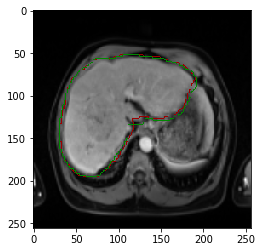

In [ ]:
imshow((100.0 * rs_img).astype(np.uint8))